## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

%config InlineBackend.figure_format='retina'

In [2]:
#import matplotlib
#matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

In [3]:
#! wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

In [4]:
#! unzip "UCI HAR Dataset.zip"

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

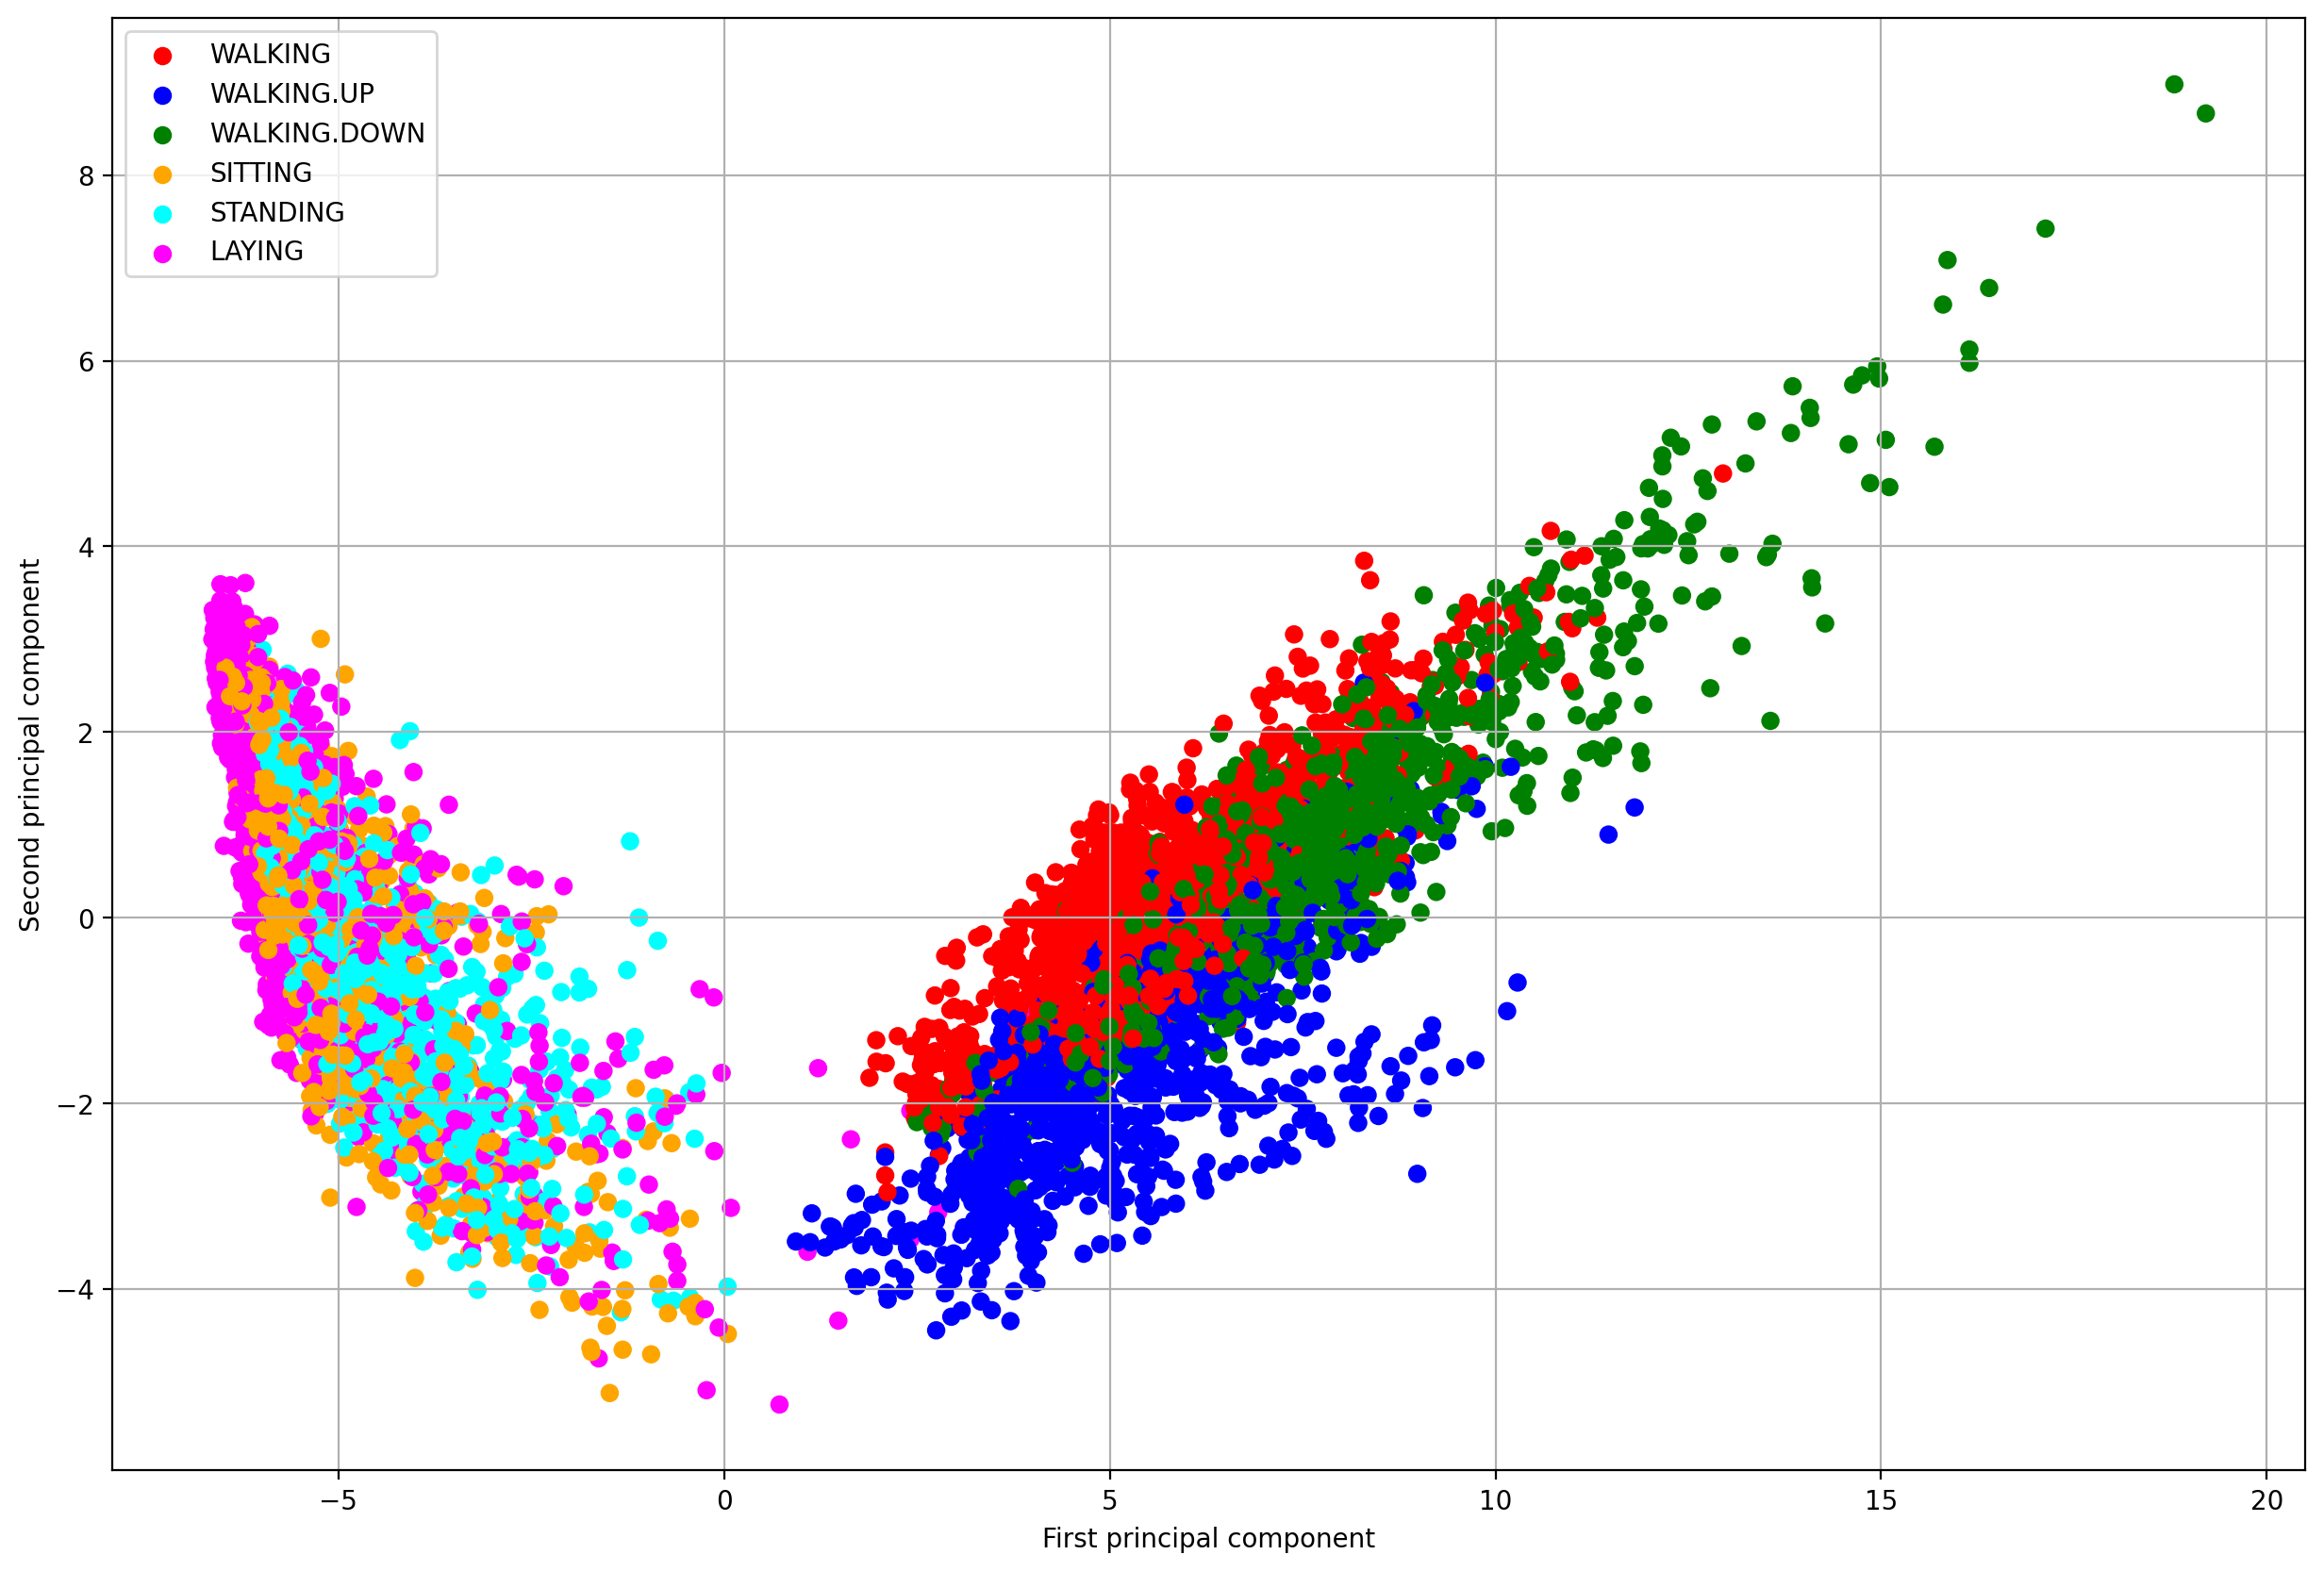

In [5]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [7]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)

n_layers = 2

# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [8]:
X_train_tensor = torch.Tensor(X_train).to(device)
y_train_tensor = torch.Tensor(y_train).squeeze().long().to(device)

X_test_tensor = torch.Tensor(X_test).to(device)
y_test_tensor = torch.Tensor(y_test).squeeze().long().to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_layers, n_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = n_hidden
        self.num_layers = n_layers
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [10]:
n_hidden = 128
n_layers = 4

model = LSTMModel(n_input, n_hidden, n_layers, n_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
train_history = []
test_history = []

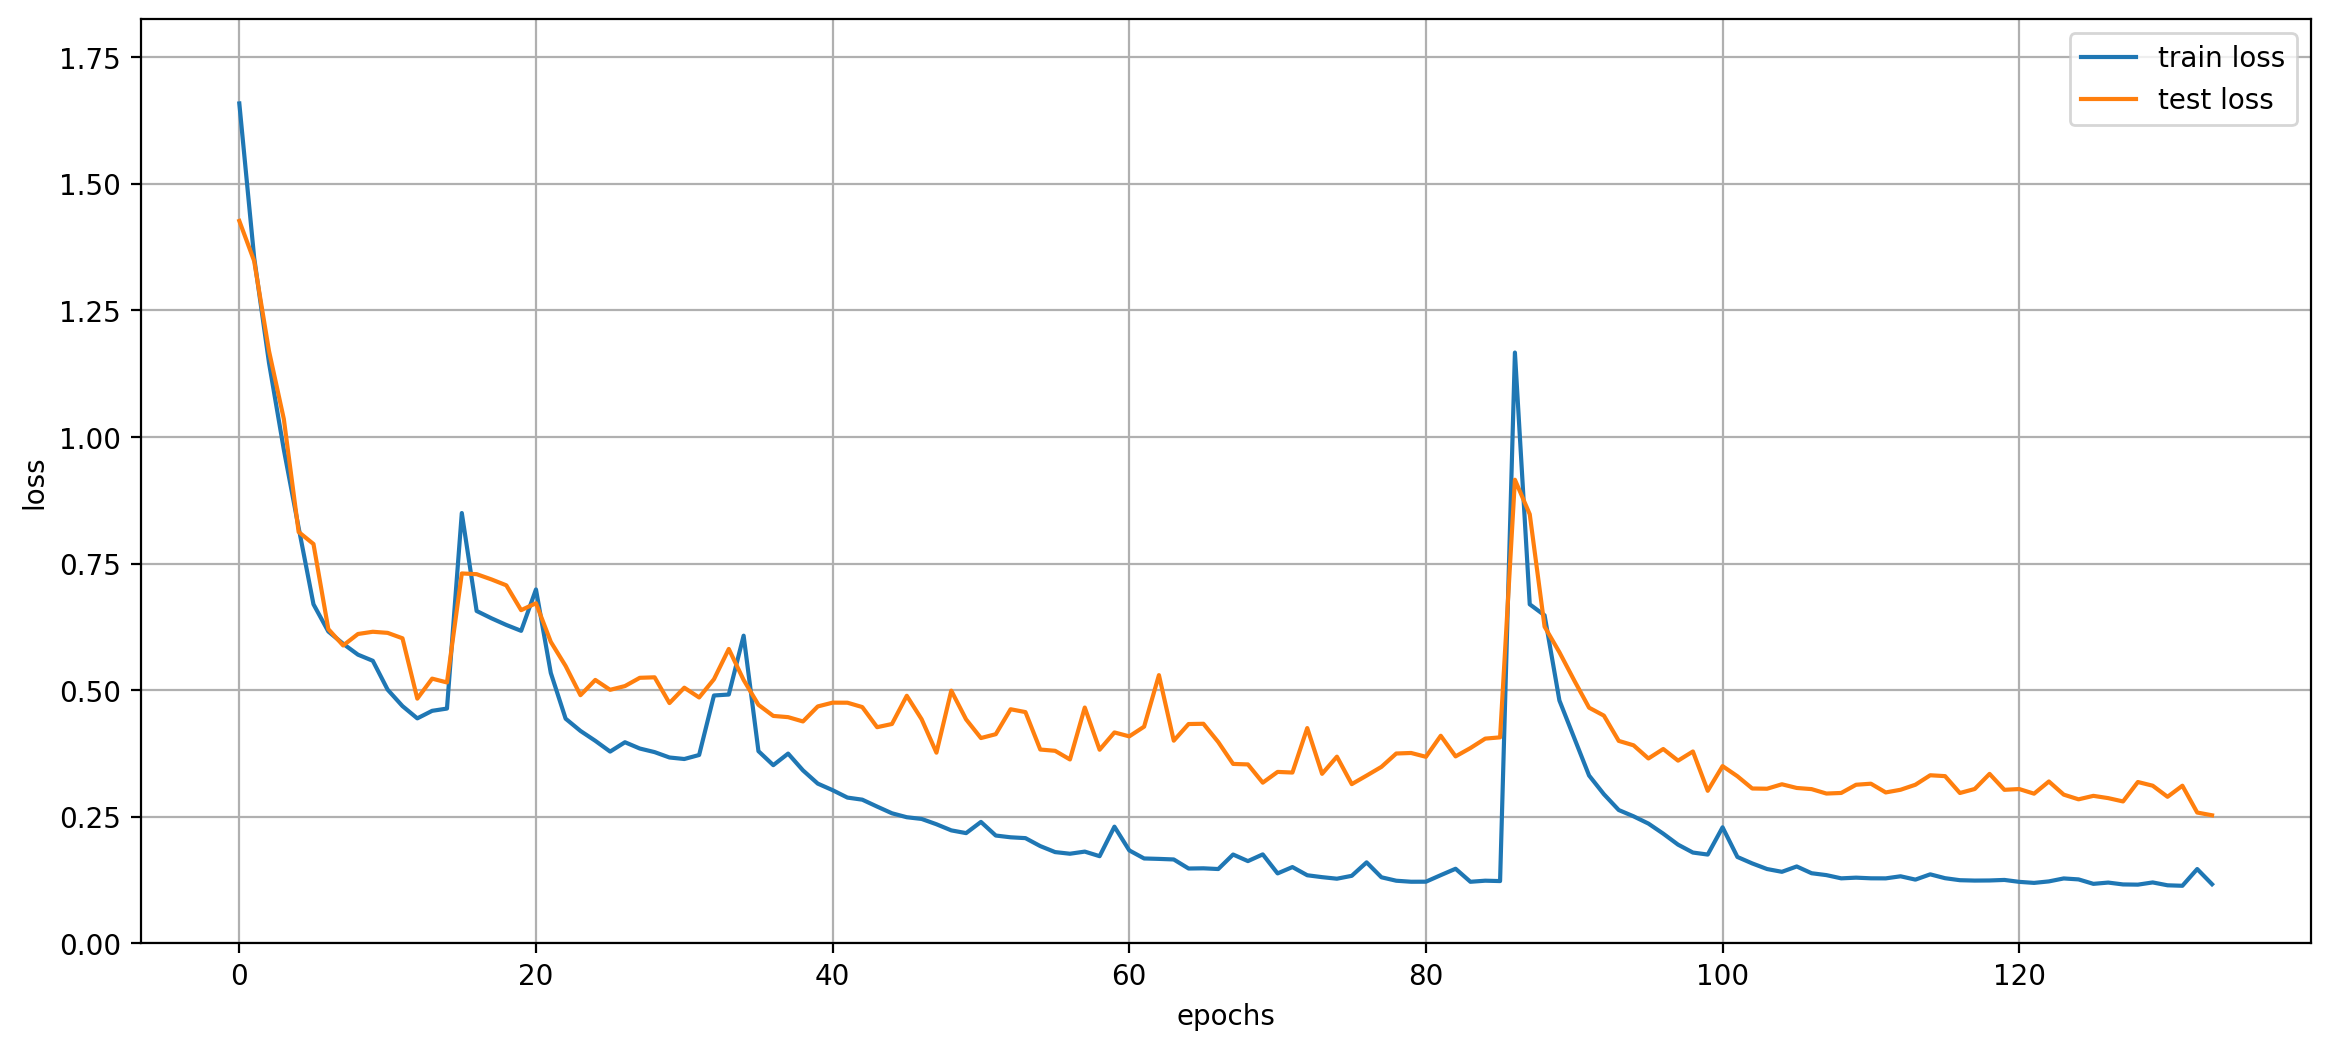

Epoch [134/1000], Train Loss: 0.1169, Test Loss: 0.2530, Test Accuracy: 91.14%
Desired accuracy achieved.


In [12]:
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        opt.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        opt.step()

    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * test_correct / test_total
        
    train_history.append(train_loss)
    test_history.append(test_loss)
    

    clear_output(True)
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.plot(train_history, label='train loss')
    plt.plot(test_history, label='test loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim((0, max(train_history + test_history)*1.1))
    plt.grid()
    plt.legend()
    plt.show()

    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, ' \
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > 91:
        print("Desired accuracy achieved.")
        break

# Выводы



### вариант 1

n_hidden = 32

n_layers = 2

Epoch [100/100], Train Loss: 0.6515, Test Loss: 0.8193, Test Accuracy: 66.07%

### вариант 2

n_hidden = 64

n_layers = 4

Epoch [84/1000], Train Loss: 0.1390, Test Loss: 0.3374, Test Accuracy: 89.38%

Вышло на плато, обучать дальше не было смысла.

### вариант 3

n_hidden = 128

n_layers = 4

На 134 эпохе запланированное значение $>91\%$ было успешно достигнуто.

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image

from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format='retina'

In [14]:
data_path = './data/train'

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [16]:
dataset = ImageFolder(root=data_path, transform=transform)

In [17]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

In [20]:
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                         nn.ReLU(),
                         nn.Dropout(0.25),
                         nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.Dropout(0.25),
                         nn.Linear(512, 50),
                         nn.LogSoftmax(dim=1))

model.fc.requires_grad = True

In [21]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

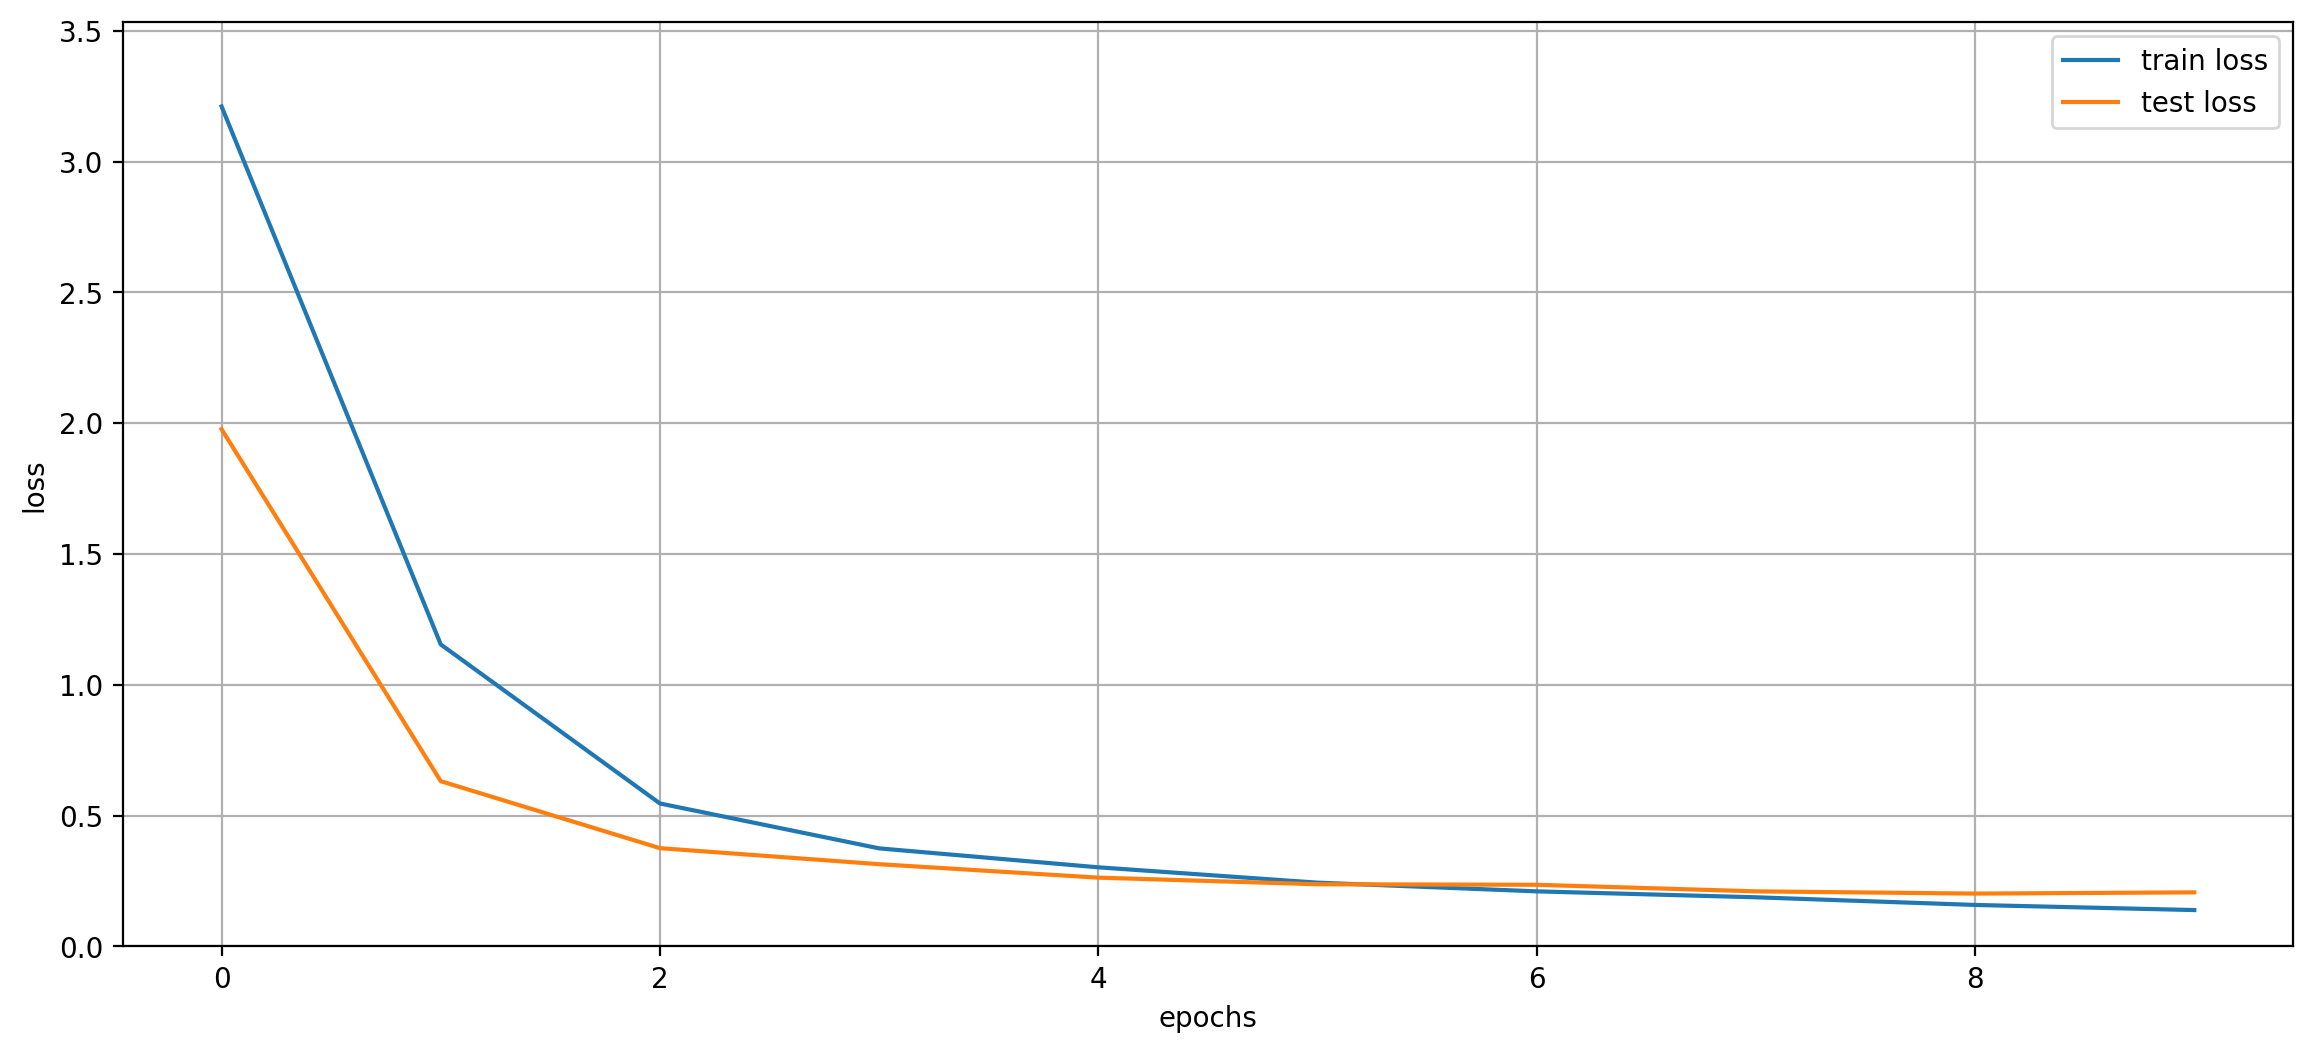

Epoch [10/10], Train Loss: 0.1391, Test Loss: 0.2067, Test Accuracy: 94.07%


In [23]:
num_epochs = 10
train_history = []
test_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)


    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()


    test_loss /= len(test_loader)
    test_accuracy = 100 * test_correct / test_total
        
    train_history.append(train_loss)
    test_history.append(test_loss)


    clear_output(True)
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.plot(train_history, label='train loss')
    plt.plot(test_history, label='test loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim((0, max(train_history + test_history)*1.1))
    plt.grid()
    plt.legend()
    plt.show()

    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, ' \
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Выводы

Построить и обучить сеть с нуля оказалось плохой затеей. Старенькая видеокарта не позволяет считать с приемлемой скоростью. Поэтому было решено дообучить resnet50, добавив в конец свои слои.

C Adam lr=0.001 за 10 эпох значение accuracy достигло 92.46%

Уменьшил lr=0.0001, стало лучше, на 10 эпохе accuracy превысило запланированные 93%, достигло 94.07%

In [39]:
import os
import re
import csv

In [33]:
val_data_path = './data/test/'

In [36]:
model.eval()

def predict_image(image_path):
    image = Image.open(image_path)
    transformed_image = transform(image)
    batch = transformed_image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

In [42]:
def extract_number(filename):
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0

image_files = [f for f in os.listdir(val_data_path) if f.endswith('.jpeg')]
image_files.sort(key=extract_number)

In [43]:
with open('predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Predicted Class'])

    for image_file in os.listdir(val_data_path):
        if image_file.endswith('.jpeg'):
            image_path = os.path.join(val_data_path, image_file)
            predicted_class = predict_image(image_path)
            writer.writerow([image_file, predicted_class])